In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(
    format="[%(asctime)s] %(levelname)s(%(name)s)\t%(message)s", level=logging.DEBUG
)

device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info("device: %s", device)

[2024-01-01 16:39:34,650] INFO(root)	device: cuda


In [4]:
# image utils
plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [5]:
# load MNIST
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.MNIST(
    root="../../data",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid = int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(
    train_valid_dataset, [nb_train, nb_valid]
)
# Load the test set
test_dataset = torchvision.datasets.MNIST(
    root="../../data", transform=torchvision.transforms.ToTensor(), train=False
)
# Prepare
num_threads = 4  # Loading the dataset is using 4 CPU threads
batch_size = 128  # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, num_workers=num_threads
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads
)

In [6]:
class VAE(nn.Module):
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
        n_hidden: int,
        n_latent: int,
    ):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.mu = nn.Linear(n_hidden, n_latent)
        self.sigma = nn.Sequential(nn.Linear(n_hidden, n_latent), nn.Softplus())

    def encode(self, x: torch.Tensor):
        h = self.encoder(x)
        return self.mu(h), self.sigma(h)

    def decode(self, z: torch.Tensor):
        return self.decoder(z)

    def forward(self, x: torch.Tensor):
        # Encode the inputs
        mu, log_var = self.encode(x)
        # Obtain latent samples and kl divergence
        z_tilde, kl_div = self.latent(mu, log_var)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde, kl_div

    def latent(self, mu: torch.Tensor, log_var: torch.Tensor):
        # reparametrization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps * std + mu

        kl_div = torch.sum(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        return z, kl_div

In [7]:
# model definition
n_in = 28 * 28
n_hidden = 512
n_latent = 3

recons_criterion = torch.nn.BCELoss(reduction="sum")

In [8]:
for beta in [0.05, 0.5, 1, 5]:
    # init model
    encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(n_in, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
    )

    decoder = nn.Sequential(
        nn.Linear(n_latent, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_in),
        nn.Sigmoid(),
    )

    model = VAE(encoder, decoder, n_hidden, n_latent).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    n_epochs = 25
    filename = f"vae_{beta}_{n_epochs}.pt"
    logger.info("training %s", filename)

    if os.path.exists(filename):
        model.load_state_dict(torch.load(filename))
        logger.info("loaded from %s", filename)

    else:
        WRITER = SummaryWriter(comment=filename)

        for epoch in range(n_epochs):
            logger.info(f"epoch {epoch+1}/{n_epochs}")

            logger.info("generating from test dataset")
            with torch.no_grad():
                imgs, _ = next(iter(test_loader))
                x = imgs[0:16, :, :, :].to(device)
                pred, _ = model(x.view(-1, 28 * 28))
                grid = torchvision.utils.make_grid(pred.view(-1, 1, 28, 28), 4)
                WRITER.add_image("test", grid, epoch)

            logger.info("generating from latent space")
            with torch.no_grad():
                n_images = 64
                z = torch.randn(n_images, n_latent).to(device)
                pred = model.decode(z).view(-1, 1, 28, 28)
                grid = torchvision.utils.make_grid(pred, 8)
                WRITER.add_image("latent", grid, epoch)

            logger.info("training")
            full_loss = 0
            recons_loss = 0
            kl_div = 0
            for i, (x, _) in tqdm(enumerate(train_loader), desc="Train"):
                x = x.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                x_tilde, kl_div_batch = model(x)
                recons_loss_batch = recons_criterion(x_tilde, x)
                full_loss_batch = recons_loss_batch + beta * kl_div_batch
                recons_loss += recons_loss_batch
                full_loss += full_loss_batch
                kl_div += kl_div_batch
                full_loss_batch.backward()
                optimizer.step()
            WRITER.add_scalar("loss/train/full", full_loss, epoch)
            WRITER.add_scalar("loss/train/reconstruction", recons_loss, epoch)
            WRITER.add_scalar("loss/train/kl_div", kl_div, epoch)

            logger.info("evaluating")
            full_loss = 0
            recons_loss = 0
            kl_div = 0
            for i, (x, _) in tqdm(enumerate(valid_loader), desc="Validation"):
                x = x.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                x_tilde, kl_div_batch = model(x)
                recons_loss_batch = recons_criterion(x_tilde, x)
                full_loss_batch = recons_loss_batch + beta * kl_div_batch
                recons_loss += recons_loss_batch
                full_loss += full_loss_batch
                kl_div += kl_div_batch
                full_loss_batch.backward()
                optimizer.step()
            WRITER.add_scalar("loss/valid/full", full_loss, epoch)
            WRITER.add_scalar("loss/valid/reconstruction", recons_loss, epoch)
            WRITER.add_scalar("loss/valid/kl_div", kl_div, epoch)

        # save weights
        torch.save(model.state_dict(), filename)
        logger.info("saved to %s", filename)

[2024-01-01 16:39:35,249] INFO(__main__)	training vae_0.05_25.pt
[2024-01-01 16:39:35,259] INFO(__main__)	loaded from vae_0.05_25.pt
[2024-01-01 16:39:35,275] INFO(__main__)	training vae_0.5_25.pt
[2024-01-01 16:39:35,283] INFO(__main__)	loaded from vae_0.5_25.pt
[2024-01-01 16:39:35,297] INFO(__main__)	training vae_1_25.pt
[2024-01-01 16:39:35,305] INFO(__main__)	loaded from vae_1_25.pt
[2024-01-01 16:39:35,318] INFO(__main__)	training vae_5_25.pt
[2024-01-01 16:39:35,327] INFO(__main__)	loaded from vae_5_25.pt


[2024-01-01 16:39:35,456] DEBUG(matplotlib.pyplot)	Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2024-01-01 16:39:35,458] DEBUG(matplotlib.pyplot)	Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2024-01-01 16:39:35,462] DEBUG(matplotlib.font_manager)	findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2024-01-01 16:39:35,462] DEBUG(matplotlib.font_manager)	findfont: score(FontEntry(fname='d:\\Documents\\ATIAM\\Temporal-Audio-VAE\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-01-01 16:39:35,463] DEBUG(matplotlib.font_manager)	findfont: score(FontEntry(fname='d:\\Documents\\ATIAM\\Temporal-Audio-VAE\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weigh

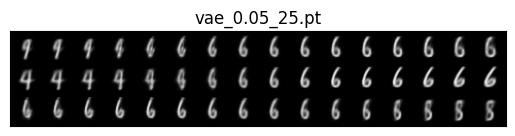

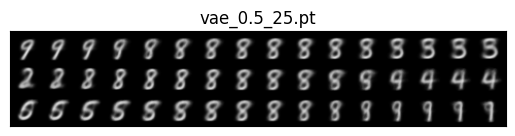

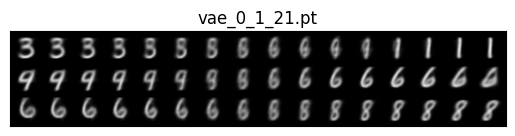

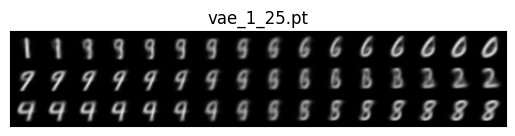

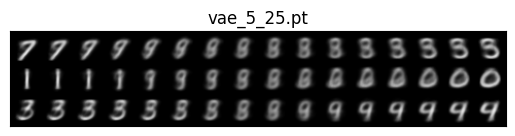

In [9]:
from pathlib import Path


def latent_explore(model, n_latent, n_images=32, min=-1, max=1, fixed=0):
    with torch.no_grad():
        n_images = 16
        z = torch.ones(n_images * n_latent, n_latent).to(device) * fixed
        for i in range(n_latent):
            z[i * n_images : (i + 1) * n_images, i] = torch.linspace(min, max, n_images)
        pred = model.decode(z).view(-1, 1, 28, 28)
        grid = torchvision.utils.make_grid(pred, n_images)
        show(grid)


for filename in Path(".").glob("vae_*.pt"):
    model.load_state_dict(torch.load(filename))
    latent_explore(model, n_latent, min=-5, max=5)
    plt.title(filename)

<StemContainer object of 3 artists>

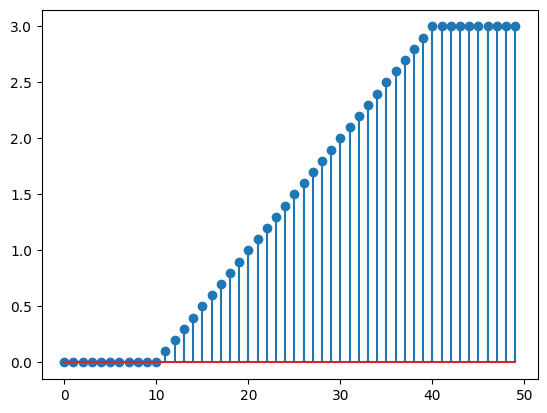

In [17]:
# beta warmup
def beta_warmup(epoch, interval, epoch_interval):
    if epoch < epoch_interval[0]:
        return interval[0]
    elif epoch > epoch_interval[1]:
        return interval[1]
    return (
        (epoch - epoch_interval[0])
        * (interval[1] - interval[0])
        / (epoch_interval[1] - epoch_interval[0])
    )


x = np.arange(0, 50)
plt.stem(x, [beta_warmup(i, (0, 3), (10, 40)) for i in x])

In [21]:
# with beta warmup
n_hidden = 128
# init model
encoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_in, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, n_hidden),
    nn.ReLU(),
)

decoder = nn.Sequential(
    nn.Linear(n_latent, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, n_in),
    nn.Sigmoid(),
)

model = VAE(encoder, decoder, n_hidden, n_latent).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 50
beta_interval = (0, 2)  # min, max
beta_epoch_interval = (10, 40)  # start, end
validate_every_nth_epoch = 3
generate_every_nth_epoch = 3

filename = f"vae_{beta_interval[0]}_{beta_interval[1]}_{n_epochs}.pt"
logger.info("training %s", filename)
logger.info("n_epochs=%d", n_epochs)

if os.path.exists(filename):
    model.load_state_dict(torch.load(filename))
    logger.info("loaded from", filename)

else:
    WRITER = SummaryWriter(comment=filename)

    beta = beta_interval[0]
    for epoch in range(n_epochs):
        beta = beta_warmup(epoch, beta_interval, beta_epoch_interval)
        logger.info(
            f"epoch {epoch+1}/{n_epochs}; beta={beta:.2f}; {epoch * len(train_dataset)} examples seen"
        )
        WRITER.add_scalar("beta", beta, epoch)

        logger.info("training")
        full_loss = 0
        recons_loss = 0
        kl_div = 0
        for i, (x, _) in tqdm(enumerate(train_loader), desc="Train"):
            x = x.view(-1, 28 * 28).to(device)
            optimizer.zero_grad()
            x_tilde, kl_div_batch = model(x)
            recons_loss_batch = recons_criterion(x_tilde, x)
            full_loss_batch = recons_loss_batch + beta * kl_div_batch
            recons_loss += recons_loss_batch
            full_loss += full_loss_batch
            kl_div += kl_div_batch
            full_loss_batch.backward()
            optimizer.step()
        WRITER.add_scalar("loss/train/full", full_loss, epoch)
        WRITER.add_scalar("loss/train/reconstruction", recons_loss, epoch)
        WRITER.add_scalar("loss/train/kl_div", kl_div, epoch)

        if epoch % validate_every_nth_epoch == 0 or epoch == n_epochs - 1:
            logger.info("evaluating")
            full_loss = 0
            recons_loss = 0
            kl_div = 0
            for i, (x, _) in tqdm(enumerate(valid_loader), desc="Validation"):
                x = x.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                x_tilde, kl_div_batch = model(x)
                recons_loss_batch = recons_criterion(x_tilde, x)
                full_loss_batch = recons_loss_batch + beta * kl_div_batch
                recons_loss += recons_loss_batch
                full_loss += full_loss_batch
                kl_div += kl_div_batch
                full_loss_batch.backward()
                optimizer.step()
            WRITER.add_scalar("loss/valid/full", full_loss, epoch)
            WRITER.add_scalar("loss/valid/reconstruction", recons_loss, epoch)
            WRITER.add_scalar("loss/valid/kl_div", kl_div, epoch)

        if epoch % generate_every_nth_epoch == 0 or epoch == n_epochs - 1:
            logger.info("generating from test dataset")
            with torch.no_grad():
                imgs, _ = next(iter(test_loader))
                x = imgs[0:16, :, :, :].to(device)
                pred, _ = model(x.view(-1, 28 * 28))
                grid = torchvision.utils.make_grid(pred.view(-1, 1, 28, 28), 4)
                WRITER.add_image("test", grid, epoch)

            logger.info("generating random from latent space")
            with torch.no_grad():
                n_images = 64
                z = torch.randn(n_images, n_latent).to(device)
                pred = model.decode(z).view(-1, 1, 28, 28)
                grid = torchvision.utils.make_grid(pred, 8)
                WRITER.add_image("latent", grid, epoch)

            logger.info("generating from latent space (fixed dimensions)")
            with torch.no_grad():
                n_images = 32
                z = torch.zeros(n_images * n_latent, n_latent).to(device)
                for i in range(n_latent):
                    z[i * n_images : (i + 1) * n_images, i] = torch.linspace(
                        -5, +5, n_images
                    )
                pred = model.decode(z).view(-1, 1, 28, 28)
                grid = torchvision.utils.make_grid(pred, n_images)
                WRITER.add_image("latent_dim", grid, epoch)

    # save weights
    torch.save(model.state_dict(), filename)
    logger.info("saved to %s", filename)

[2024-01-01 17:08:42,487] INFO(__main__)	training vae_0_2_50.pt
[2024-01-01 17:08:42,488] INFO(__main__)	n_epochs=50
[2024-01-01 17:08:42,492] INFO(__main__)	epoch 1/50; beta=0.00; 0 examples seen
[2024-01-01 17:08:42,493] INFO(__main__)	training
Train: 375it [00:02, 136.78it/s]
[2024-01-01 17:08:56,683] INFO(__main__)	evaluating
Validation: 94it [00:04, 21.66it/s]
[2024-01-01 17:09:01,352] INFO(__main__)	generating from test dataset
[2024-01-01 17:09:05,294] INFO(__main__)	generating random from latent space
[2024-01-01 17:09:05,321] INFO(__main__)	generating from latent space (fixed dimensions)
[2024-01-01 17:09:05,371] INFO(__main__)	epoch 2/50; beta=0.00; 48000 examples seen
[2024-01-01 17:09:05,393] INFO(__main__)	training
Train: 375it [00:02, 135.33it/s]
[2024-01-01 17:09:19,700] INFO(__main__)	epoch 3/50; beta=0.00; 96000 examples seen
[2024-01-01 17:09:19,702] INFO(__main__)	training
Train: 375it [00:02, 132.53it/s]
[2024-01-01 17:09:34,093] INFO(__main__)	epoch 4/50; beta=0.00